In [3]:
import os 
import shutil
import pickle
import jax 
from jax import grad, jit, vmap, jacfwd, jacrev
import emcee
import sacc
import jax_cosmo as jc
import jax.numpy as jnp
import numpy as np
import matplotlib.pylab as plt
from jax import config
from numpyro.handlers import seed
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, BarkerMH, init_to_median
from cobaya.run import run 

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [4]:
jc.power.USE_EMU = False

In [5]:
ZMAX = 3.5
TNAME_WL = "LSSTwl__"
TNAME_GC = "LSSTgc__"
ELLMAX_GC = 300 
ELLMAX_WL = 3000
ELLMIN = 2
NELL = 30

In [6]:
def get_nz(sfile, tracertype="wl"):
    tracers_names = list(sfile.tracers.keys())

    if tracertype == "wl":
        tname = TNAME_WL
    else:
        tname = TNAME_GC 
    nbin = sum([tname in tracers_names[i] for i in range(len(tracers_names))])
    
    nz_distributions = list()
    for i in range(nbin):
        name = tname + str(i)
        distribution = sfile.tracers[name]
        jaxred = jc.redshift.custom_nz(
            distribution.z.astype("float64"),
            distribution.nz.astype("float64"),
            zmax=ZMAX,
        )
        nz_distributions.append(jaxred)

    return nz_distributions


def calculate_lmax_gc(sfile, kmax):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum([TNAME_GC in tracers_names[i] for i in range(len(tracers_names))])
    vanillacosmo = jc.Planck15()
    lmaxs = list()
    for i in range(nbin_gc):
        tracer = sfile.tracers[f"{TNAME_GC}{i}"]
        zmid = jnp.average(jnp.asarray(tracer.z), weights=jnp.asarray(tracer.nz))
        chi = jc.background.radial_comoving_distance(vanillacosmo, 1.0 / (1.0 + zmid))
        minmax = jnp.concatenate([10.0 * jnp.ones(1), kmax * chi - 0.5], dtype=int)
        lmax = jnp.max(minmax)
        lmaxs.append(lmax)
    return lmaxs


def scale_cuts(sfile, kmax=0.15, lmin_wl=30, lmax_wl=2000):
    # First we remove all B-modes
    sfile.remove_selection(data_type="cl_bb")
    sfile.remove_selection(data_type="cl_be")
    sfile.remove_selection(data_type="cl_eb")
    sfile.remove_selection(data_type="cl_0b")

    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum([TNAME_GC in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum([TNAME_WL in tracers_names[i] for i in range(len(tracers_names))])
    lmaxs_gc = calculate_lmax_gc(sfile, kmax)

    for i, lmax in enumerate(lmaxs_gc):
        print(f"Maximum ell is {lmax}")
        tname_1 = f"{TNAME_GC}{i}"

        # Remove from galaxy clustering
        sfile.remove_selection(
            data_type="cl_00", tracers=(tname_1, tname_1), ell__gt=lmax
        )

        # Remove from galaxy-galaxy lensing
        for j in range(nbin_wl):
            tname_2 = f"{TNAME_WL}{j}"
            sfile.remove_selection(
                data_type="cl_0e", tracers=(tname_1, tname_2), ell__gt=lmax
            )

    # apply scale cut for weak lensing
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tname_1 = f"{TNAME_WL}{i}"
            tname_2 = f"{TNAME_WL}{j}"
            sfile.remove_selection(
                data_type="cl_ee", tracers=(tname_1, tname_2), ell__gt=lmax_wl
            )
            sfile.remove_selection(
                data_type="cl_ee", tracers=(tname_1, tname_2), ell__lt=lmin_wl
            )

    return sfile

def get_data_type(tracer_combination):
    if "gc" in tracer_combination[0] and "gc" in tracer_combination[1]:
        dtype = "cl_00"
    elif "gc" in tracer_combination[0] and "wl" in tracer_combination[1]:
        dtype = "cl_0e"
    elif "wl" in tracer_combination[0] and "wl" in tracer_combination[1]:
        dtype = "cl_ee"
    return dtype


def get_ells_bandwindow(sfile, tracer_name_1, tracer_name_2, ellmax):
    dtype = get_data_type((tracer_name_1, tracer_name_2))
    idx = sfile.indices(data_type=dtype, tracers=(tracer_name_1, tracer_name_2))
    window = sfile.get_bandpower_windows(idx)
    fine_ells = window.values
    indices = (fine_ells >= 2) & (fine_ells <= ellmax)
    fine_ells = jnp.asarray(fine_ells[indices], dtype=jnp.float32)
    bandwindow = jnp.asarray(window.weight[indices])
    return fine_ells, bandwindow


def extract_bandwindow(sfile):
    tracers_names = list(sfile.tracers.keys())
    nbin_gc = sum([TNAME_GC in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum([TNAME_WL in tracers_names[i] for i in range(len(tracers_names))])
    

    # galaxy-galaxy
    record_gc = []
    for i in range(nbin_gc):
        tracer_name = f"{TNAME_GC}{i}"
        ells_gc, bandwindow = get_ells_bandwindow(
            sfile, tracer_name, tracer_name, ELLMAX_GC
        )
        record_gc.append(bandwindow)

    # galaxy-shear
    record_gc_wl = []
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f"{TNAME_GC}{i}"
            tracer_name_2 = f"{TNAME_WL}{j}"
            ells_gc_wl, bandwindow = get_ells_bandwindow(
                sfile, tracer_name_1, tracer_name_2, ELLMAX_GC
            )
            record_gc_wl.append(bandwindow)

    # shear-shear
    record_wl = []
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f"{TNAME_WL}{i}"
            tracer_name_2 = f"{TNAME_WL}{j}"
            ells_wl, bandwindow = get_ells_bandwindow(
                sfile, tracer_name_1, tracer_name_2, ELLMAX_WL
            )
            record_wl.append(bandwindow)

    return (ells_gc, record_gc), (ells_gc_wl, record_gc_wl), (ells_wl, record_wl)

def extract_data_covariance(saccfile):
    tracers_names = list(saccfile.tracers.keys())
    nbin_gc = sum([TNAME_GC in tracers_names[i] for i in range(len(tracers_names))])
    nbin_wl = sum([TNAME_WL in tracers_names[i] for i in range(len(tracers_names))])

    indices = []
    # galaxy-galaxy
    for i in range(nbin_gc):
        tracer_name = f"{TNAME_GC}{i}"
        _, _, ind = saccfile.get_ell_cl(
            "cl_00", tracer_name, tracer_name, return_cov=False, return_ind=True
        )
        indices += list(ind)

    # galaxy-shear
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            tracer_name_1 = f"{TNAME_GC}{i}"
            tracer_name_2 = f"{TNAME_WL}{j}"
            _, _, ind = saccfile.get_ell_cl(
                "cl_0e", tracer_name_1, tracer_name_2, return_cov=False, return_ind=True
            )
            indices += list(ind)

    # shear-shear
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            tracer_name_1 = f"{TNAME_WL}{i}"
            tracer_name_2 = f"{TNAME_WL}{j}"
            _, _, ind = saccfile.get_ell_cl(
                "cl_ee", tracer_name_1, tracer_name_2, return_cov=False, return_ind=True
            )
            indices += list(ind)

    indices = np.array(indices)
    covariance = saccfile.covariance.covmat[indices][:, indices]
    data = saccfile.mean[indices]
    return jnp.array(data), jnp.array(covariance)


def get_index_pairs(nbin1, nbin2=None, auto=False):
    cl_index = list()
    if nbin2 is not None:
        for i in range(nbin1):
            for j in range(nbin2):
                cl_index.append([i, j + nbin1])
    elif auto:
        for i in range(nbin1):
            cl_index.append([i, i])
    else:
        for i in range(nbin1):
            for j in range(i, nbin1):
                cl_index.append([i, j])
    return cl_index


def get_params_vec(cosmo, multiplicative, deltaz, ia_params, bias, deltaz_gc):
    mparam_1, mparam_2, mparam_3, mparam_4, mparam_5 = multiplicative
    dz1, dz2, dz3, dz4, dz5 = deltaz
    a_ia_param, eta_param = ia_params
    b1, b2, b3, b4, b5, b6, b7, b8, b9, b10 = bias
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5, dz_gc_6, dz_gc_7, dz_gc_8, dz_gc_9, dz_gc_10 = deltaz_gc
    return jnp.array(
        [
            cosmo.sigma8,
            cosmo.Omega_c,
            cosmo.Omega_b,
            cosmo.h,
            cosmo.n_s,
            mparam_1,
            mparam_2,
            mparam_3,
            mparam_4,
            mparam_5,
            dz1,
            dz2,
            dz3,
            dz4,
            dz5,
            a_ia_param,
            eta_param,
            b1,
            b2,
            b3,
            b4,
            b5,
            b6,
            b7,
            b8,
            b9,
            b10,
            dz_gc_1,
            dz_gc_2,
            dz_gc_3,
            dz_gc_4,
            dz_gc_5,
            dz_gc_6,
            dz_gc_7,
            dz_gc_8,
            dz_gc_9,
            dz_gc_10,
        ]
    )


def unpack_params_vec(params):
    cosmo = jc.Cosmology(
        sigma8=params[0],
        Omega_c=params[1],
        Omega_b=params[2],
        h=params[3],
        n_s=params[4],
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )
    mparam_1, mparam_2, mparam_3, mparam_4, mparam_5 = params[5:10]
    dz1, dz2, dz3, dz4, dz5 = params[10:15]
    a_ia_param, eta_param = params[15], params[16]
    b1, b2, b3, b4, b5, b6, b7, b8, b9, b10 = params[17], params[18], params[19], params[20], params[21], params[22], params[23], params[24], params[25], params[26]
    dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5, dz_gc_6, dz_gc_7, dz_gc_8, dz_gc_9, dz_gc_10 = (
        params[27],
        params[28],
        params[29],
        params[30],
        params[31],
        params[32],
        params[33],
        params[34],
        params[35],
        params[36]
    )
    return (
        cosmo,
        [mparam_1, mparam_2, mparam_3, mparam_4, mparam_5],
        [dz1, dz2, dz3, dz4, dz5],
        [a_ia_param, eta_param],
        [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10],
        [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5, dz_gc_6, dz_gc_7, dz_gc_8, dz_gc_9, dz_gc_10],
    )


def interpolator(ellnew, ellcoarse, powerspectrum):
    ellnew_log = jnp.log(ellnew)
    ellcoarse_log = jnp.log(ellcoarse)
    powerspectrum_log = jnp.log(powerspectrum)
    ps_interp = jnp.interp(ellnew_log, ellcoarse_log, powerspectrum_log)
    return jnp.exp(ps_interp)


def get_bandpowers_gc(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        cls_wl_interp = interpolator(
            bandwindow_ells, ells_coarse, powerspectra[counter]
        )
        bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
        recordbandpowers.append(bandpowers)
        counter += 1
    return recordbandpowers


def get_bandpowers_gc_wl(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_gc, nbin_wl
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_gc):
        for j in range(nbin_wl):
            cls_wl_interp = interpolator(
                bandwindow_ells, ells_coarse, powerspectra[counter]
            )
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers


def get_bandpowers_wl(
    bandwindow_ells, bandwindow_matrix, ells_coarse, powerspectra, nbin_wl
):
    recordbandpowers = []
    counter = 0
    for i in range(nbin_wl):
        for j in range(i, nbin_wl):
            cls_wl_interp = interpolator(
                bandwindow_ells, ells_coarse, powerspectra[counter]
            )
            bandpowers = bandwindow_matrix[counter].T @ cls_wl_interp
            recordbandpowers.append(bandpowers)
            counter += 1
    return recordbandpowers


def get_gc_powerspectra(parameters, jax_nz_gc):
    (
        cosmo,
        multiplicative,
        deltaz_wl,
        (a_ia_param, eta_param),
        bias,
        deltaz_gc,
    ) = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
    nz_gc_sys = [
        jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX)
        for nzi, dzi in zip(jax_nz_gc, deltaz_gc)
    ]
    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc = get_index_pairs(nbin_gc, auto=True)
    ps_gc = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_gc, index_pairs=idx_pairs_gc
    )
    return ps_gc, ells_coarse, nbin_gc


def get_gc_wl_powerspectra(parameters, jax_nz_gc, jax_nz_wl):
    (
        cosmo,
        multiplicative,
        deltaz_wl,
        (a_ia_param, eta_param),
        bias,
        deltaz_gc,
    ) = unpack_params_vec(parameters)
    nbin_gc = len(deltaz_gc)
    nbin_wl = len(deltaz_wl)

    # apply all the systematics here (shifts, multiplicative bias, intrinsic alignment)
    nz_wl_sys = [
        jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_wl, deltaz_wl)
    ]
    nz_gc_sys = [
        jc.redshift.systematic_shift(nzi, dzi) for nzi, dzi in zip(jax_nz_gc, deltaz_gc)
    ]
    gc_biases = [jc.bias.constant_linear_bias(bi) for bi in bias]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)

    probes_gc = [jc.probes.NumberCounts(nz_gc_sys, gc_biases)]
    probes_wl = [
        jc.probes.WeakLensing(
            nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative
        )
    ]
    probes_gc_wl = probes_gc + probes_wl

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_GC, NELL, dtype=jnp.float32)
    idx_pairs_gc_wl = get_index_pairs(nbin_gc, nbin_wl, auto=False)
    ps_gc_wl = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_gc_wl, index_pairs=idx_pairs_gc_wl
    )
    return ps_gc_wl, ells_coarse, nbin_gc, nbin_wl


def get_wl_powerspectra(parameters, jax_nz_wl):
    cosmo, multiplicative, deltaz_wl, (a_ia_param, eta_param) = unpack_params_vec(
        parameters
    )[0:4]
    nbin_wl = len(deltaz_wl)

    nz_wl_sys = [
        jc.redshift.systematic_shift(nzi, dzi, zmax=ZMAX)
        for nzi, dzi in zip(jax_nz_wl, deltaz_wl)
    ]
    b_ia = jc.bias.des_y1_ia_bias(a_ia_param, eta_param, 0.62)
    probes_wl = [
        jc.probes.WeakLensing(
            nz_wl_sys, ia_bias=b_ia, multiplicative_bias=multiplicative
        )
    ]

    ells_coarse = jnp.geomspace(ELLMIN, ELLMAX_WL, NELL, dtype=jnp.float32)
    idx_pairs_wl = get_index_pairs(nbin_wl, auto=False)
    ps_wl = jc.angular_cl.angular_cl(
        cosmo, ells_coarse, probes_wl, index_pairs=idx_pairs_wl
    )
    return ps_wl, ells_coarse, nbin_wl


def gc_bandpower_calculation(parameters, jax_nz_gc, bandwindow_ells, bandwindow_matrix):
    ps_gc, ells_coarse, nbin_gc = get_gc_powerspectra(parameters, jax_nz_gc)
    gc_bandpowers = get_bandpowers_gc(
        bandwindow_ells, bandwindow_matrix, ells_coarse, ps_gc, nbin_gc
    )
    return gc_bandpowers


def gc_wl_bandpower_calculation(
    parameters, jax_nz_gc, jax_nz_wl, bandwindow_ells, bandwindow_matrix
):
    ps_gc_wl, ells_coarse, nbin_gc, nbin_wl = get_gc_wl_powerspectra(
        parameters, jax_nz_gc, jax_nz_wl
    )
    gc_wl_bandpowers = get_bandpowers_gc_wl(
        bandwindow_ells, bandwindow_matrix, ells_coarse, ps_gc_wl, nbin_gc, nbin_wl
    )
    return gc_wl_bandpowers


def wl_bandpower_calculation(parameters, jax_nz_wl, bandwindow_ells, bandwindow_matrix):
    ps_wl, ells_coarse, nbin_wl = get_wl_powerspectra(parameters, jax_nz_wl)
    wl_bandpowers = get_bandpowers_wl(
        bandwindow_ells, bandwindow_matrix, ells_coarse, ps_wl, nbin_wl
    )
    return wl_bandpowers


def get_bandpowers_probes(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory_gc = gc_bandpower_calculation(parameters, jax_nz_gc, bw_gc[0], bw_gc[1])
    theory_gc_wl = gc_wl_bandpower_calculation(
        parameters, jax_nz_gc, jax_nz_wl, bw_gc_wl[0], bw_gc_wl[1]
    )
    theory_wl = wl_bandpower_calculation(parameters, jax_nz_wl, bw_wl[0], bw_wl[1])
    return theory_gc, theory_gc_wl, theory_wl


def get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory_gc, theory_gc_wl, theory_wl = get_bandpowers_probes(
        parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl
    )
    concat_theory_gc = jnp.concatenate(theory_gc)
    concat_theory_gc_wl = jnp.concatenate(theory_gc_wl)
    concat_theory_wl = jnp.concatenate(theory_wl)
    return jnp.concatenate([concat_theory_gc, concat_theory_gc_wl, concat_theory_wl])

def numpyro_model(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    #  Cosmological params
    sigma8 = numpyro.sample("sigma8", dist.Uniform(0.6, 1.0))
    Omegac = numpyro.sample("Omegac", dist.Uniform(0.14, 0.35))
    Omegab = numpyro.sample("Omegab", dist.Uniform(0.03, 0.055))
    hubble = numpyro.sample("hubble", dist.Uniform(0.64, 0.82))
    ns = numpyro.sample("ns", dist.Uniform(0.87, 1.07))
    cosmo = jc.Cosmology(
        Omega_c=Omegac,
        sigma8=sigma8,
        Omega_b=Omegab,
        h=hubble,
        n_s=ns,
        w0=-1.0,
        Omega_k=0.0,
        wa=0.0,
    )

    # multiplicative factor (weak lensing)
    m1 = numpyro.sample("m1", dist.Normal(0.012, 0.023))
    m2 = numpyro.sample("m2", dist.Normal(0.012, 0.023))
    m3 = numpyro.sample("m3", dist.Normal(0.012, 0.023))
    m4 = numpyro.sample("m4", dist.Normal(0.012, 0.023))
    m5 = numpyro.sample("m5", dist.Normal(0.012, 0.023))
    multiplicative = [m1, m2, m3, m4, m5]

    # shifts (weak lensing)
    dz_wl_1 = numpyro.sample("dz_wl_1", dist.Normal(0.0, 0.02))
    dz_wl_2 = numpyro.sample("dz_wl_2", dist.Normal(0.0, 0.02))
    dz_wl_3 = numpyro.sample("dz_wl_3", dist.Normal(0.0, 0.02))
    dz_wl_4 = numpyro.sample("dz_wl_4", dist.Normal(0.0, 0.02))
    dz_wl_5 = numpyro.sample("dz_wl_5", dist.Normal(0.0, 0.02))
    dz_wl = [dz_wl_1, dz_wl_2, dz_wl_3, dz_wl_4, dz_wl_5]
    nbin_wl = len(dz_wl)

    # intrinsic alignment
    a_ia = numpyro.sample("a_ia", dist.Uniform(-1, 1))
    eta = numpyro.sample("eta", dist.Uniform(-5.0, 5.0))
    ia_params = [a_ia, eta]

    # multiplicative bias (galaxy clustering)
    b1 = numpyro.sample("b1", dist.Uniform(0.8, 3.0))
    b2 = numpyro.sample("b2", dist.Uniform(0.8, 3.0))
    b3 = numpyro.sample("b3", dist.Uniform(0.8, 3.0))
    b4 = numpyro.sample("b4", dist.Uniform(0.8, 3.0))
    b5 = numpyro.sample("b5", dist.Uniform(0.8, 3.0))
    b6 = numpyro.sample("b6", dist.Uniform(0.8, 3.0))
    b7 = numpyro.sample("b7", dist.Uniform(0.8, 3.0))
    b8 = numpyro.sample("b8", dist.Uniform(0.8, 3.0))
    b9 = numpyro.sample("b9", dist.Uniform(0.8, 3.0))
    b10 = numpyro.sample("b10", dist.Uniform(0.8, 3.0))
    bias = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10]

    # shifts (galaxy clustering)
    dz_gc_1 = numpyro.sample("dz_gc_1", dist.Normal(0.0, 0.01))
    dz_gc_2 = numpyro.sample("dz_gc_2", dist.Normal(0.0, 0.01))
    dz_gc_3 = numpyro.sample("dz_gc_3", dist.Normal(0.0, 0.01))
    dz_gc_4 = numpyro.sample("dz_gc_4", dist.Normal(0.0, 0.01))
    dz_gc_5 = numpyro.sample("dz_gc_5", dist.Normal(0.0, 0.01))
    dz_gc_6 = numpyro.sample("dz_gc_6", dist.Normal(0.0, 0.01))
    dz_gc_7 = numpyro.sample("dz_gc_7", dist.Normal(0.0, 0.01))
    dz_gc_8 = numpyro.sample("dz_gc_8", dist.Normal(0.0, 0.01))
    dz_gc_9 = numpyro.sample("dz_gc_9", dist.Normal(0.0, 0.01))
    dz_gc_10 = numpyro.sample("dz_gc_10", dist.Normal(0.0, 0.01))
    dz_gc = [dz_gc_1, dz_gc_2, dz_gc_3, dz_gc_4, dz_gc_5, dz_gc_6, dz_gc_7, dz_gc_8, dz_gc_9, dz_gc_10]

    parameters = get_params_vec(cosmo, multiplicative, dz_wl, ia_params, bias, dz_gc)
    theory = get_bandpowers_theory(
        parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl
    )
    sampling_distribution = dist.MultivariateNormal(theory, precision_matrix=precision)
    theory_sample = numpyro.sample("y", sampling_distribution, obs=data)
    log_prob = sampling_distribution.log_prob(theory_sample)
    return theory_sample, log_prob

def emcee_logprior(parameters):

    # cosmological parameters 
    logp_sigma8 = jax.scipy.stats.uniform.logpdf(parameters[0], 0.60, 0.40)
    logp_omegac = jax.scipy.stats.uniform.logpdf(parameters[1], 0.14, 0.21)
    logp_omegab = jax.scipy.stats.uniform.logpdf(parameters[2], 0.03, 0.025)
    logp_hubble = jax.scipy.stats.uniform.logpdf(parameters[3], 0.64, 0.18)
    logp_ns = jax.scipy.stats.uniform.logpdf(parameters[4], 0.87, 0.20)

    # multiplicative factor (weak lensing)
    logp_m1 = jax.scipy.stats.norm.logpdf(parameters[5], 0.012, 0.023)
    logp_m2 = jax.scipy.stats.norm.logpdf(parameters[6], 0.012, 0.023)
    logp_m3 = jax.scipy.stats.norm.logpdf(parameters[7], 0.012, 0.023)
    logp_m4 = jax.scipy.stats.norm.logpdf(parameters[8], 0.012, 0.023)
    logp_m5 = jax.scipy.stats.norm.logpdf(parameters[9], 0.012, 0.023)

    # shifts (weak lensing)
    logp_dz_wl_1 = jax.scipy.stats.norm.logpdf(parameters[10], -0.001, 0.016) 
    logp_dz_wl_2 = jax.scipy.stats.norm.logpdf(parameters[11], -0.019, 0.013)
    logp_dz_wl_3 = jax.scipy.stats.norm.logpdf(parameters[12], 0.009, 0.011)
    logp_dz_wl_4 = jax.scipy.stats.norm.logpdf(parameters[13], -0.018, 0.022)
    logp_dz_wl_5 = jax.scipy.stats.norm.logpdf(parameters[14], 0.0, 0.022)

    # intrinsic alignment
    logp_a_ia = jax.scipy.stats.uniform.logpdf(parameters[15], -1, 2)
    logp_eta = jax.scipy.stats.uniform.logpdf(parameters[16], -5, 10)  

    # multiplicative bias (galaxy clustering)
    logp_b1 = jax.scipy.stats.uniform.logpdf(parameters[17], 0.8, 2.2)
    logp_b2 = jax.scipy.stats.uniform.logpdf(parameters[18], 0.8, 2.2)
    logp_b3 = jax.scipy.stats.uniform.logpdf(parameters[19], 0.8, 2.2)
    logp_b4 = jax.scipy.stats.uniform.logpdf(parameters[20], 0.8, 2.2)
    logp_b5 = jax.scipy.stats.uniform.logpdf(parameters[21], 0.8, 2.2)
    logp_b6 = jax.scipy.stats.uniform.logpdf(parameters[22], 0.8, 2.2)
    logp_b7 = jax.scipy.stats.uniform.logpdf(parameters[23], 0.8, 2.2)
    logp_b8 = jax.scipy.stats.uniform.logpdf(parameters[24], 0.8, 2.2)
    logp_b9 = jax.scipy.stats.uniform.logpdf(parameters[25], 0.8, 2.2)
    logp_b10 = jax.scipy.stats.uniform.logpdf(parameters[26], 0.8, 2.2)

    # shifts (galaxy clustering)
    logp_dz_gc_1 = jax.scipy.stats.norm.logpdf(parameters[27], 0.0, 0.01)
    logp_dz_gc_2 = jax.scipy.stats.norm.logpdf(parameters[28], 0.0, 0.01)
    logp_dz_gc_3 = jax.scipy.stats.norm.logpdf(parameters[29], 0.0, 0.01)
    logp_dz_gc_4 = jax.scipy.stats.norm.logpdf(parameters[30], 0.0, 0.01)
    logp_dz_gc_5 = jax.scipy.stats.norm.logpdf(parameters[31], 0.0, 0.01)
    logp_dz_gc_6 = jax.scipy.stats.norm.logpdf(parameters[32], 0.0, 0.01)
    logp_dz_gc_7 = jax.scipy.stats.norm.logpdf(parameters[33], 0.0, 0.01)
    logp_dz_gc_8 = jax.scipy.stats.norm.logpdf(parameters[34], 0.0, 0.01)
    logp_dz_gc_9 = jax.scipy.stats.norm.logpdf(parameters[35], 0.0, 0.01)
    logp_dz_gc_10 = jax.scipy.stats.norm.logpdf(parameters[36], 0.0, 0.01)
    
    logp_cosmology = logp_sigma8 + logp_omegac + logp_omegab + logp_hubble + logp_ns 
    logp_multiplicative = logp_m1 + logp_m2 + logp_m3 + logp_m4 + logp_m5
    logp_shifts_wl = logp_dz_wl_1 + logp_dz_wl_2 + logp_dz_wl_3 + logp_dz_wl_4 + logp_dz_wl_5
    logp_intrinsic = logp_a_ia + logp_eta 
    logp_bias = logp_b1 + logp_b2 + logp_b3 + logp_b4 + logp_b5 + logp_b6 + logp_b7 + logp_b8 + logp_b9 + logp_b10
    logp_shifts_gc = logp_dz_gc_1 + logp_dz_gc_2 + logp_dz_gc_3 + logp_dz_gc_4 + logp_dz_gc_5 + logp_dz_gc_6 + logp_dz_gc_7 + logp_dz_gc_8 + logp_dz_gc_9 + logp_dz_gc_10
    logp = logp_cosmology + logp_multiplicative + logp_shifts_wl + logp_intrinsic + logp_bias + logp_shifts_gc
    if not jnp.isfinite(logp):
        logp = -1E32
    return logp


## EMCEE

In [7]:
@jax.jit
def jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

def emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    theory = jit_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    diff = data - theory 
    chi2 = diff @ precision @ diff
    return -0.5*jnp.min(jnp.array([chi2, 1E32]))

@jax.jit
def jit_emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    return emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

def emcee_logpost(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
    loglike = emcee_loglike(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
    logprior = emcee_logprior(parameters)
    return loglike + logprior    

In [8]:
saccfile = sacc.Sacc.load_fits("data/lsst_mock_data.fits")
jax_nz_wl = get_nz(saccfile, tracertype="wl")
jax_nz_gc = get_nz(saccfile, tracertype="gc")
saccfile_cut = scale_cuts(saccfile, kmax=0.15, lmin_wl=30, lmax_wl=ELLMAX_WL)
bw_gc, bw_gc_wl, bw_wl = extract_bandwindow(saccfile_cut)
data, covariance = extract_data_covariance(saccfile_cut)
precision = jnp.linalg.inv(covariance)

/home/arrykrishna/anaconda3/envs/desemu/lib/python3.9/site-packages/sacc/sacc.py:376: UserWarning: Empty index selected
  warnings.warn("Empty index selected")


Maximum ell is 107
Maximum ell is 144
Maximum ell is 180
Maximum ell is 215
Maximum ell is 246
Maximum ell is 277
Maximum ell is 305
Maximum ell is 332
Maximum ell is 357
Maximum ell is 381


/home/arrykrishna/anaconda3/envs/desemu/lib/python3.9/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


In [9]:
cosmo = jc.Cosmology(sigma8=0.82, Omega_c = 0.265, Omega_b=0.045, h = 0.7, n_s=0.965, w0=-1., Omega_k=0., wa=0.)

parameters = get_params_vec(cosmo, 
                       [1e-3]*5, # multiplicative
                       [1e-3]*5, # delta shear 
                       [0.0, 0.0], # ia 
                       [1.376695, 1.451179, 1.528404, 1.607983, 1.689579, 1.772899, 1.857700, 1.943754, 2.030887, 2.118943], # bias
                       [1e-3]*10) # delta galaxy

In [23]:
# theory = get_bandpowers_theory(parameters, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

# with seed(rng_seed=40):
#     theory, logp = numpyro_model(data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

# diff = data - theory 

# diff @ precision @ diff

# theory[0:10]

# data[0:10]

In [24]:
emcee_logpost(parameters, data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Not using the emulator
Not using the emulator
Not using the emulator


DeviceArray(-11677.41556847, dtype=float64)

## NUTS

In [99]:
NWARMUP = 10
NSAMPLES = 10

In [108]:
nuts_kernel = NUTS(numpyro_model, step_size=0.01, init_strategy=init_to_median, dense_mass=True, max_tree_depth=8)

In [109]:
mcmc_nuts = MCMC(nuts_kernel, num_warmup=NWARMUP, num_samples=NSAMPLES, num_chains=1, 
            # chain_method="vectorized",
            progress_bar=True)

In [110]:
mcmc_nuts.run(jax.random.PRNGKey(253), data, precision, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

Using the emulator
Using the emulator
Using the emulator
Using the emulator
Using the emulator
Using the emulator
Using the emulator
Using the emulator
Using the emulator


  0%|                                                                                                | 0/20 [00:00<?, ?it/s]

Using the emulator
Using the emulator
Using the emulator


2024-04-09 11:13:29.277346: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit__body_fn] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-04-09 11:29:12.686812: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 17m43.40955605s

********************************
[Compiling module jit__body_fn] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
sample: 100%|████████████████████████████████████| 20/20 [28:11<00:00, 84.60s/it, 31 steps of size 9.78e-04. acc. prob=0.42]


In [ ]:
mcmc_nuts.get_samples()

# Cobaya

In [10]:
PROPOSAL = 1e-3

In [11]:
def get_output_folder(iteration, mainfolder = 'CobayaLSST/'):
    if jc.power.USE_EMU:
        folder = mainfolder + f"emulator_{iteration}/"
    else:
        folder = mainfolder + f"jaxcosmo_{iteration}/"
    return folder

In [12]:
params={

    # cosmological parameters
    "sigma8": {
        "prior": {"min": 0.60, "max": 1.0},
        "ref": {"dist": "norm", "loc": 0.85, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "omegac": {
        "prior": {"min": 0.14, "max": 0.35},
        "ref": {"dist": "norm", "loc": 0.25, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "omegab": {
        "prior": {"min": 0.03, "max": 0.055},
        "ref": {"dist": "norm", "loc": 0.04, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "hubble": {
        "prior": {"min": 0.64, "max": 0.82},
        "ref": {"dist": "norm", "loc": 0.70, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "ns": {
        "prior": {"min": 0.87, "max": 1.07},
        "ref": {"dist": "norm", "loc": 1.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    # multiplicative bias parameters
    "m1": {
        "prior": {"dist": "norm", "loc": 0.012, "scale": 0.023},
        "ref": {"dist": "norm", "loc": 0.012, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "m2": {
        "prior": {"dist": "norm", "loc": 0.012, "scale": 0.023},
        "ref": {"dist": "norm", "loc": 0.012, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "m3": {
        "prior": {"dist": "norm", "loc": 0.012, "scale": 0.023},
        "ref": {"dist": "norm", "loc": 0.012, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "m4": {
        "prior": {"dist": "norm", "loc": 0.012, "scale": 0.023},
        "ref": {"dist": "norm", "loc": 0.012, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "m5": {
        "prior": {"dist": "norm", "loc": 0.012, "scale": 0.023},
        "ref": {"dist": "norm", "loc": 0.012, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    # shifts weak lensing bins
    "dz_wl_1": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "proposal": PROPOSAL,
    },
    "dz_wl_2": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "proposal": PROPOSAL,
    },
    "dz_wl_3": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "proposal": PROPOSAL,
    },
    "dz_wl_4": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "proposal": PROPOSAL,
    },
    "dz_wl_5": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.02},
        "proposal": PROPOSAL,
    },
    # intrinsic alignment
    "a_ia": {
        "prior": {"min": -1.0, "max": 1.0},
        "ref": 0.0,  # {"dist": "norm", "loc": 0.0, "scale": 0.001},
        "proposal": PROPOSAL,
    },
    "eta": {
        "prior": {"min": -5.0, "max": 5.0},
        "ref": 0.0,  # {"dist": "norm", "loc": 0.0, "scale": 0.0001},
        "proposal": PROPOSAL,
    },
    # multiplicative bias (galaxy clustering) 
    "b1": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.376695, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b2": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.451179, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b3": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.528404, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b4": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.607983, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b5": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.689579, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b6": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.772899, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b7": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.857700, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b8": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 1.943754, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b9": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 2.030887, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "b10": {
        "prior": {"min": 0.8, "max": 3.0},
        "ref": {"dist": "norm", "loc": 2.118943, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    # shifts (galaxy clustering)
    "dz_gc_1": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_2": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_3": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_4": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_5": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_6": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_7": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_8": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_9": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
    "dz_gc_10": {
        "prior": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "ref": {"dist": "norm", "loc": 0.0, "scale": 0.01},
        "proposal": PROPOSAL,
    },
}

In [13]:
class CobayaLSST:
    
    def __init__(self, data, precision, params, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
        self.data = data 
        self.precision = precision
        self.params = params
        self.pnames = list(params.keys())
        self._postinit(jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)
        
    def _postinit(self, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl):
        self.jax_nz_gc = jax_nz_gc
        self.jax_nz_wl = jax_nz_wl 
        self.bw_gc = bw_gc
        self.bw_gc_wl = bw_gc_wl 
        self.bw_wl = bw_wl 
        
    def loglike(self, **kwargs):
        params = jnp.array([kwargs[p] for p in self.pnames])
        theory = jit_theory(params, self.jax_nz_gc, self.jax_nz_wl, self.bw_gc, self.bw_gc_wl, self.bw_wl)
        diff = self.data - theory
        chi2 = diff @ self.precision @ diff
        logl = -0.5 * jnp.nan_to_num(chi2, nan=np.inf, posinf=np.inf, neginf=np.inf)
        return logl.item()

    def run_sampler(self, nsamples, iteration, criterion = 1E-2):
        info = {"likelihood": {"LSSTlike": {
                "external": self.loglike,
                "input_params": self.pnames}}}
        
        info["params"] = self.params
        info["sampler"] = {"mcmc": {"max_samples": nsamples, "Rminus1_stop": criterion}}
        
        path = get_output_folder(iteration)
        if os.path.exists(path) and os.path.isdir(path):
            shutil.rmtree(path)
        info["output"] = path + "lsst"
        updated_info, sampler = run(info, debug=False)
        return sampler

In [14]:
testing = CobayaLSST(data, precision, params, jax_nz_gc, jax_nz_wl, bw_gc, bw_gc_wl, bw_wl)

In [22]:
sampler = testing.run_sampler(nsamples=5000, iteration=1)

INFO:output:Output to be read-from/written-into folder 'CobayaLSST/jaxcosmo_1', with prefix 'lsst'


[output] Output to be read-from/written-into folder 'CobayaLSST/jaxcosmo_1', with prefix 'lsst'


INFO:lsstlike:Initialized external likelihood.


[lsstlike] Initialized external likelihood.


INFO:mcmc:Getting initial point... (this may take a few seconds)


[mcmc] Getting initial point... (this may take a few seconds)


INFO:mcmc:Initial point: sigma8:0.8551601, omegac:0.2300539, omegab:0.0400957, hubble:0.6883323, ns:0.9954298, m1:0.01347638, m2:0.01156594, m3:0.01381363, m4:0.01178945, m5:0.01357248, dz_wl_1:-0.01564453, dz_wl_2:0.03897947, dz_wl_3:-0.02395227, dz_wl_4:0.002447815, dz_wl_5:0.02675857, a_ia:0, eta:0, b1:1.37449, b2:1.450283, b3:1.513557, b4:1.602309, b5:1.671189, b6:1.763321, b7:1.854974, b8:1.935371, b9:2.052089, b10:2.128582, dz_gc_1:-0.02204855, dz_gc_2:-0.003216828, dz_gc_3:-0.006993184, dz_gc_4:-0.004753858, dz_gc_5:0.009137522, dz_gc_6:0.01301575, dz_gc_7:-0.01004925, dz_gc_8:-0.01861751, dz_gc_9:-0.01708842, dz_gc_10:0.005447812


[mcmc] Initial point: sigma8:0.8551601, omegac:0.2300539, omegab:0.0400957, hubble:0.6883323, ns:0.9954298, m1:0.01347638, m2:0.01156594, m3:0.01381363, m4:0.01178945, m5:0.01357248, dz_wl_1:-0.01564453, dz_wl_2:0.03897947, dz_wl_3:-0.02395227, dz_wl_4:0.002447815, dz_wl_5:0.02675857, a_ia:0, eta:0, b1:1.37449, b2:1.450283, b3:1.513557, b4:1.602309, b5:1.671189, b6:1.763321, b7:1.854974, b8:1.935371, b9:2.052089, b10:2.128582, dz_gc_1:-0.02204855, dz_gc_2:-0.003216828, dz_gc_3:-0.006993184, dz_gc_4:-0.004753858, dz_gc_5:0.009137522, dz_gc_6:0.01301575, dz_gc_7:-0.01004925, dz_gc_8:-0.01861751, dz_gc_9:-0.01708842, dz_gc_10:0.005447812


INFO:model:Measuring speeds... (this may take a few seconds)


[model] Measuring speeds... (this may take a few seconds)


INFO:model:Setting measured speeds (per sec): {LSSTlike: 17.7}


[model] Setting measured speeds (per sec): {LSSTlike: 17.7}


INFO:mcmc:Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).


INFO:mcmc:Sampling!


[mcmc] Sampling!


INFO:mcmc:Progress @ 2024-04-15 10:13:59 : 1 steps taken, and 0 accepted.


[mcmc] Progress @ 2024-04-15 10:13:59 : 1 steps taken, and 0 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:14:59 : 1044 steps taken, and 518 accepted.


[mcmc] Progress @ 2024-04-15 10:14:59 : 1044 steps taken, and 518 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:16:00 : 2067 steps taken, and 1024 accepted.


[mcmc] Progress @ 2024-04-15 10:16:00 : 2067 steps taken, and 1024 accepted.


INFO:mcmc:Learn + convergence test @ 1480 samples accepted.


[mcmc] Learn + convergence test @ 1480 samples accepted.


INFO:mcmc: - Acceptance rate: 0.493


[mcmc]  - Acceptance rate: 0.493


INFO:mcmc: - Convergence of means: R-1 = 82.779619 after 1184 accepted steps


[mcmc]  - Convergence of means: R-1 = 82.779619 after 1184 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 10:17:00 : 3078 steps taken, and 1527 accepted.


[mcmc] Progress @ 2024-04-15 10:17:00 : 3078 steps taken, and 1527 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:18:00 : 4111 steps taken, and 2023 accepted.


[mcmc] Progress @ 2024-04-15 10:18:00 : 4111 steps taken, and 2023 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:19:00 : 5108 steps taken, and 2516 accepted.


[mcmc] Progress @ 2024-04-15 10:19:00 : 5108 steps taken, and 2516 accepted.


INFO:mcmc:Learn + convergence test @ 2960 samples accepted.


[mcmc] Learn + convergence test @ 2960 samples accepted.


INFO:mcmc: - Acceptance rate: 0.493


[mcmc]  - Acceptance rate: 0.493


INFO:mcmc: - Convergence of means: R-1 = 83.919334 after 2368 accepted steps


[mcmc]  - Convergence of means: R-1 = 83.919334 after 2368 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 10:20:00 : 6105 steps taken, and 3016 accepted.


[mcmc] Progress @ 2024-04-15 10:20:00 : 6105 steps taken, and 3016 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:21:00 : 7118 steps taken, and 3539 accepted.


[mcmc] Progress @ 2024-04-15 10:21:00 : 7118 steps taken, and 3539 accepted.


INFO:mcmc:Progress @ 2024-04-15 10:22:00 : 8123 steps taken, and 4037 accepted.


[mcmc] Progress @ 2024-04-15 10:22:00 : 8123 steps taken, and 4037 accepted.


INFO:mcmc:Learn + convergence test @ 4440 samples accepted.


[mcmc] Learn + convergence test @ 4440 samples accepted.


INFO:mcmc: - Acceptance rate: 0.500


[mcmc]  - Acceptance rate: 0.500


INFO:mcmc: - Convergence of means: R-1 = 88.185107 after 3552 accepted steps


[mcmc]  - Convergence of means: R-1 = 88.185107 after 3552 accepted steps


INFO:mcmc:Convergence less than requested for updates: waiting until the next convergence check.


[mcmc] Convergence less than requested for updates: waiting until the next convergence check.


INFO:mcmc:Progress @ 2024-04-15 10:23:00 : 9099 steps taken, and 4547 accepted.


[mcmc] Progress @ 2024-04-15 10:23:00 : 9099 steps taken, and 4547 accepted.


INFO:mcmc:Reached maximum number of accepted steps allowed (5000). Stopping.


[mcmc] Reached maximum number of accepted steps allowed (5000). Stopping.


INFO:mcmc:Sampling complete after 5000 accepted steps.


[mcmc] Sampling complete after 5000 accepted steps.


In [23]:
samples = sampler.samples().data

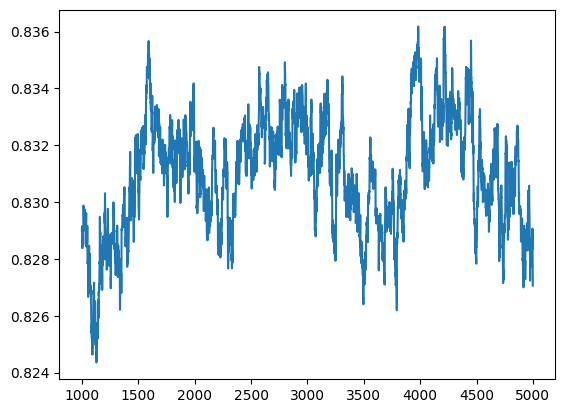

In [27]:
plt.plot(samples.sigma8.loc[1000:])
plt.show()

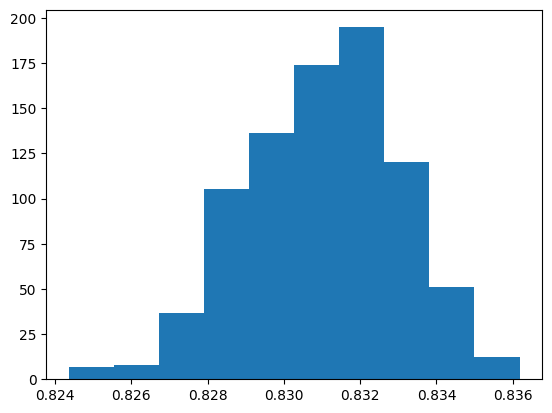

In [28]:
plt.hist(samples.sigma8.loc[1000:], density = True)
plt.show()

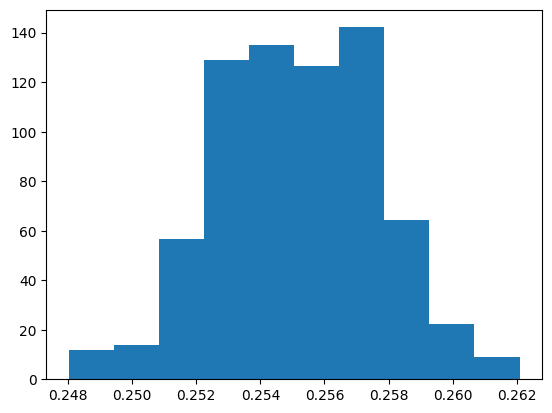

In [29]:
plt.hist(samples.omegac.loc[1000:], density = True)
plt.show()